In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
from FORCE.learning import Regression
from FORCE.utils import plot_learning_forecast

### Obtain a Learning Rate for Fixed-Bottom OSW <br />

In [2]:
# Load Data - 4C Project Database (Paid subscription - Please don't commit data to repository)
fp = os.path.join(os.getcwd(), "data", "4Cdb_jan2023_OWMR.csv")
projects = pd.read_csv(fp, header=2) #, encoding="ISO-8859-1") # encoding may be required for databases that have project names with special characters

In [3]:
# Define regression parameters

filters = {
   'Capacity MW (Max)': (149, ),
   'Full Commissioning': (2014, 2022),
#    'CAPEX_per_kw': (800, 8000.0) # confirm with Matt we should remove
}

to_aggregate = {
    'United Kingdom': 'United Kingdom',
    'Germany': 'Germany',
    'Netherlands': 'Netherlands',
    'Belgium' : 'Belgium',
    'China': 'China',
    'Denmark': 'Denmark',
}

to_drop = []

fixed_predictors = [
            'Country Name',
            'Water Depth Max (m)',
            # 'Turbine MW (Max)',
            'Capacity MW (Max)', # fixed is already commercial so we include this in the list to exclude effects from LR
            'Distance From Shore Auto (km)',
            ]
float_predictors = [
            'Country Name',
            'Water Depth Max (m)',
            # 'Turbine MW (Max)',
            'Capacity MW (Max)', # uncomment for ATB: same learning rate, but starting points are different: comment if going from demo to commercial scale
            'Distance From Shore Auto (km)',
            ]



In [4]:
# Def run regression
def run_regression(projects, filters, to_aggregate, to_drop, predictors):
    """
    Run FORCE Regression with given settings.

    Parameters
    ----------
    projects : DataFrame
    filters : dict
    to_aggregate : dict
    to_drop : list
        List of countries to drop.
    """

    regression = Regression(
        projects,
        y_var="log CAPEX_per_kw",
        filters=filters,
        regression_variables=predictors,
        aggregate_countries=to_aggregate,
        drop_categorical=["United Kingdom"],
        drop_country=to_drop,
        log_vars=['Cumulative Capacity', 'CAPEX_per_kw'],
    )
    print(regression.summary)
    return regression

### We need to update exchange_rates.yaml before finalizing anything <br/>
I had to hack in AED and ISK currencies. Plus there was a hack in FORCE just making everying after 2017 convert based on exchange rate in 2017

In [5]:
# Display regression results and learning rate
regression = run_regression(projects, filters, to_aggregate, to_drop, fixed_predictors)
print("Experience factor b: ", regression.cumulative_capacity_fit)
print('Learning rate (%):', np.round(regression.learning_rate, 3) * 100)

                            OLS Regression Results                            
Dep. Variable:       log CAPEX_per_kw   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     51.54
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           4.55e-35
Time:                        14:57:21   Log-Likelihood:                 71.291
No. Observations:                 118   AIC:                            -122.6
Df Residuals:                     108   BIC:                            -94.87
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

C:\Users\pduffy\Documents\repos\FORCE\FORCE\learning.py:187: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = ret.groupby(["Full Commissioning"]).sum()["Capacity MW (Max)"]
C:\Users\pduffy\Documents\repos\FORCE\FORCE\learning.py:307: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, data in df.iteritems():


### Estimate future deployment

In [6]:
DIR = "C:/Users/pduffy/Documents/repos/FORCE/examples/"
FORECAST_FP_FIXED = os.path.join(DIR, "data", "2023_fixed_forecast_0.csv")
FORECAST_FIXED = pd.read_csv(FORECAST_FP_FIXED).set_index("year").to_dict()["simple_avg"] # simple_avg	WoodMac_q4_2022	GWEC_2022	DNV_ETO

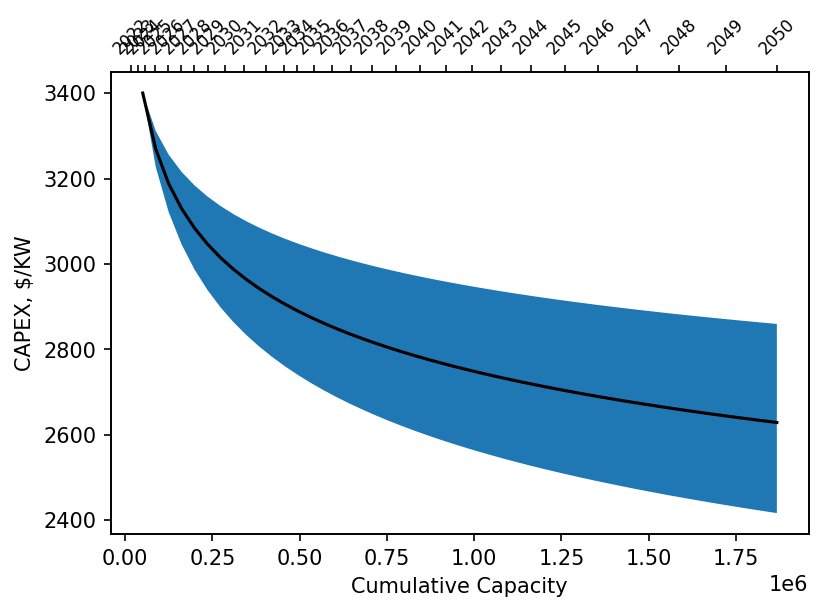

In [7]:
axes = plot_learning_forecast(
    # installed=regression.installed_capacity,
    # capex=regression.current_capex,
    installed=50623, # From 2022 Market Report
    capex=3400, # From 2022 Market Report
    fit=regression.cumulative_capacity_fit,
    forecast=FORECAST_FIXED,
    bse=regression.cumulative_capacity_bse,
    data_file="results/projected_capex.csv",
    figsize=(6, 4),
    dpi=150,
    perc_change=False
)

Things to improve: <br/>
- currency exchange rates <br/>
- selection of years <br/>
- rolling average learning rate or update every few years<br/>
- to linearize or not to linearize? <br/>
- additional deployment forecasts <br/>
- floating *